In [1]:
load("MARIMA1StepFore.data") # MARIMA forecast
load("MSE-CRBM.data") # Error CRBM

# Get valid models

Some of the ARIMA models had convergence issues, therefore we filter them

In [2]:
errorTh <- 10 #These models are broken

In [3]:
notnullARIMA  <- sapply(fore, function(x) {
        !is.null(x) && (sum(is.na(x$nrmse)) + sum(x$nrmse > errorTh, na.rm=TRUE)) == 0                
    }
)

In [4]:
notnullCRBM  <- sapply(error.crbm, function(x) {
        !is.null(x) && (sum(is.na(x$nrmse)) + sum(x$nrmse > errorTh, na.rm=TRUE)) == 0                
    }
)

In [5]:
sum(notnullARIMA)

[1] 283

In [6]:
sum(notnullCRBM)

[1] 308

In [7]:
sum(notnullCRBM & notnullARIMA)

[1] 220

In [8]:
e.arima <- fore[notnullCRBM & notnullARIMA]

In [9]:
correct <- names(e.arima)

In [10]:
e.crbm <- error.crbm[(names(error.crbm) %in% correct)]

# Preprocess

## MSE

In [11]:
mse.crbm <- lapply(e.crbm, function(x)x$mse)
mse.crbm <- as.data.frame(do.call("rbind", mse.crbm))
names(mse.crbm) <-  c("CRBM.rotationGPS","CRBM.sog","CRBM.bathymetry")

In [12]:
mse.arima <- lapply(e.arima, function(x)x$mse)
mse.arima <- as.data.frame(do.call("rbind", mse.arima))
names(mse.arima) <-  c("MARIMA.rotationGPS","MARIMA.sog","MARIMA.bathymetry")

In [13]:
mse <- cbind(mse.arima, mse.crbm)

## NRMSE

In [14]:
nrmse.crbm <- lapply(e.crbm, function(x)x$nrmse)
nrmse.crbm <- as.data.frame(do.call("rbind", nrmse.crbm))
nrmse.crbm$model <- "CRBM"
#names(nrmse.crbm) <-  c("CRBM.rotationGPS","CRBM.sog","CRBM.bathymetry")
names(nrmse.crbm) <-  c("rotationGPS","sog","bathymetry", "model")

In [15]:
nrmse.arima <- lapply(e.arima, function(x)x$nrmse)
nrmse.arima <- as.data.frame(do.call("rbind", nrmse.arima))
nrmse.arima$model <- "ARIMA"
names(nrmse.arima) <-  c("rotationGPS","sog","bathymetry", "model")

In [16]:
nrmse <- rbind(nrmse.arima, nrmse.crbm)

### Remove Infs

In [17]:
nrmse <- nrmse[-which(is.infinite(nrmse[,3])),]

In [18]:
str(nrmse)

'data.frame':	439 obs. of  4 variables:
 $ rotationGPS: num  0.905 0.98 0.948 0.988 0.706 ...
 $ sog        : num  0.0405 0.0374 0.025 0.0205 0.2005 ...
 $ bathymetry : num  0.0722 0.1361 0.1383 0.1573 0.6579 ...
 $ model      : chr  "ARIMA" "ARIMA" "ARIMA" "ARIMA" ...


# Comparison

## Mean and Median

In [19]:
print("CRBM")
print("Mean")
nrmse.crbm <- nrmse[nrmse$model == "CRBM",-4]
colMeans(nrmse.crbm)
print("Mode:")
qu <- apply(nrmse.crbm,2,quantile)
qu[3,]

print("MARIMA")
print("Mean")
nrmse.arima <- nrmse[nrmse$model == "ARIMA",-4]
colMeans(nrmse.arima)
print("Mode:")
qu <- apply(nrmse.arima,2,quantile)
qu[3,]

[1] "CRBM"
[1] "Mean"


rotationGPS         sog  bathymetry 
 0.73817771  0.09929606  0.14343400

[1] "Mode:"


rotationGPS         sog  bathymetry 
 0.74068316  0.05222317  0.10010355

[1] "MARIMA"
[1] "Mean"


rotationGPS         sog  bathymetry 
  0.9214859   0.1287267   0.1736394

[1] "Mode:"


rotationGPS         sog  bathymetry 
 0.93657426  0.03355423  0.09453712

## Boxplots

In [20]:
colMeans(nrmse)
qu <- apply(nrmse,2,quantile)
qu[3,]

ERROR: Error in colMeans(nrmse): 'x' must be numeric


In [21]:
library(reshape2)
test.m <- melt(nrmse)

Using model as id variables


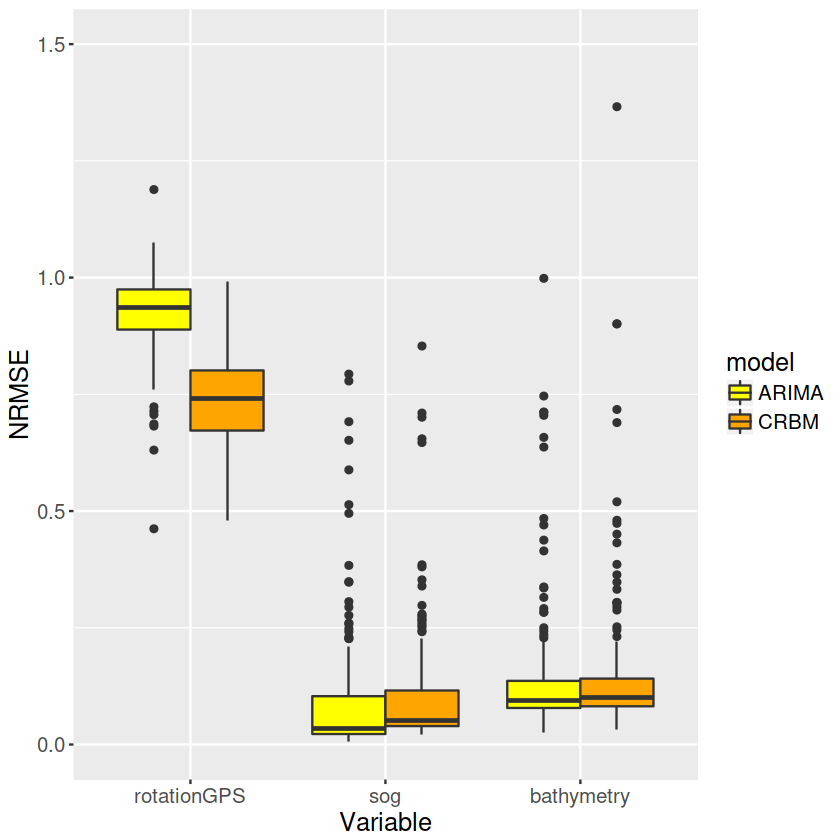

In [22]:
library(ggplot2)
ggplot(test.m, aes(x = variable, y = value, fill = model)) +
  theme(text = element_text(size=15)) +
  coord_cartesian(ylim = c(0, 1.5)) +
  xlab("Variable")+
  ylab("NRMSE")+
  geom_boxplot() +
  scale_fill_manual(values = c("yellow", "orange"))